# Burst Center Frequency

Finds the center frequency of a burst by integrating over time and fitting a gaussian to the spectrum

In [6]:
from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts = pd.read_csv('bursts.csv')
bursts

,filename,edge,angle,peak,sigmax,sigmay,Slope,drift (mhz/ms),drift error (mhz/ms)
0,01_puppi_57747_C0531+33_0558_5.dm559.72.calibP...,1525,1.720000,10429.0,173.731526,47.364587,-6.652439,-1039.308995,0.617101
1,02_puppi_57747_C0531+33_0558_1183.dm559.72.cal...,1850,23.770000,5692.0,177.080918,44.911875,-4.736866,-739.419463,1.279131
2,03_puppi_57747_C0531+33_0558_1202.dm559.72.cal...,1975,-1.520000,5668.0,169.749001,19.463885,-19.669528,-2813.966383,5.239849
3,04_puppi_57747_C0531+33_0558_25437.dm559.72.ca...,1450,1.710000,5038.0,160.360329,26.706231,-7.137257,-1109.319273,40.321594
4,05_puppi_57747_C0531+33_0558_3683.dm559.72.cal...,1450,1.639204,5031.0,37.747383,166.280492,-14.595503,-2109.819670,124.715830
5,06_puppi_57747_C0531+33_0558_3687.dm559.72.cal...,1150,1.590000,5569.0,156.557708,12.416683,-52.066970,-6317.730503,30.736619
6,07_puppi_57747_C0531+33_0558_3688.dm559.72.cal...,1590,1.720000,5821.0,102.259272,38.969184,-6.652439,-1028.172298,2.175251
7,08_puppi_57747_C0531+33_0558_3689.dm559.72.cal...,2000,1.990000,5666.0,171.395398,64.792725,-2.244076,-340.010864,0.162096
8,09_puppi_57747_C0531+33_0558_3690.dm559.72.cal...,1600,2.240000,5041.0,133.024941,89.628038,-1.264288,-191.824534,9.704662
9,10_puppi_57747_C0531+33_0558_12568.dm559.72.ca...,800,-1.390000,5132.0,130.605616,47.074113,-5.470689,-846.471217,34.730967


Data loaded


noise removal: 100%|██████████| 411/411 [00:05<00:00, 75.56it/s]


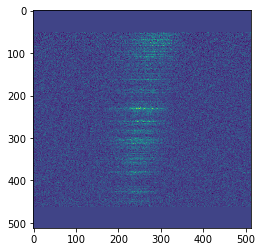

In [36]:
burst = bursts.iloc[0]
burstnum = burst[0][:2].strip('0') if burst[0][:2][0] == '0' else burst[0][:2]

folder = 'data'
filename = burst.filename
edge = burst.edge

junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
Q, U, V = None, None, None
n = len(junk)
print("Data loaded")

binmax = int(nbin[n-1])+1
frequencymax = (int(nchan[n-1])+1)
intensity = np.zeros((frequencymax, binmax))

X = np.zeros(binmax)
Y = np.zeros(frequencymax)

# what are these?
tmin = 500 
tmax = 1500

#### 1. remove noise
intensitynoise1 = np.zeros(tmin-1)
intensitynoise2 = np.zeros(binmax-tmax)
for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=False):

    Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

    for j in range(1,tmin) :

        intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


    for j in range(tmax+1,binmax+1) :

        intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

    a = sum(intensitynoise1)
    b = sum(intensitynoise2)

    for j in range(1,binmax+1) :
        X[j-1] = j-1
        intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

burstwindow = intensity[:,edge:edge+frequencymax]




gauss params: [ 31.67832041 -82.82332999 422.23919022]


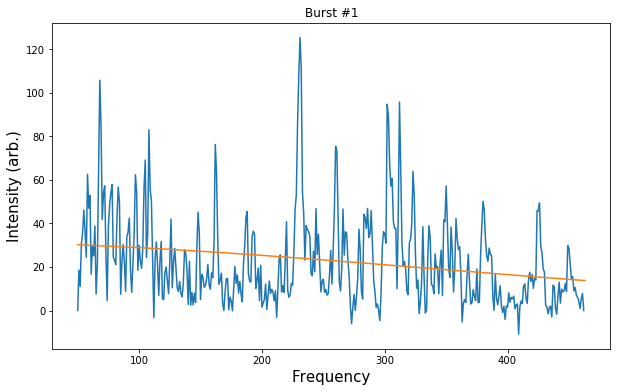

In [198]:
plt.figure(figsize=(10,8))
# plt.imshow(burstwindow, interpolation='bicubic', origin='lower', cmap='gray')
burstextents = [4100.78125 * 1e-3, (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
freqspectrum = pd.DataFrame(burstwindow[:,:].sum(axis=1)[:, None])
# 50:463
data = freqspectrum[50:463][0]

ax = data.plot(figsize=(10, 6), title='Burst #{}'.format(burstnum))
# ax.set_xlim(burstextents[0], burstextents[1])
ax.set_xlabel('Frequency', size=15)
ax.set_ylabel('Intensity (arb.)', size=15)

def gaussian(x, a, xo, sigma) :
	return a*np.exp(-(x-xo)**2/(2*(sigma**2)))

def fitgaussian(data):
    # use curve-fit (non-linear leastsq)
    x = data.keys()
    xo = sum(x*data)/sum(data)
    sigma = np.sqrt(sum(data*(x-xo)**2)/sum(data))
    guess = [np.max(data), xo, sigma]
    popt, pcov = scipy.optimize.curve_fit(gaussian, x, data, p0=guess)
    return popt, pcov

popt, pcov = fitgaussian(data)
print('gauss params:', popt) # A, c, s
x = np.linspace(data.keys().start, data.keys().stop, num=1000)
# popt = [100, 220, 100]
plt.plot(x, gaussian(x, *popt))

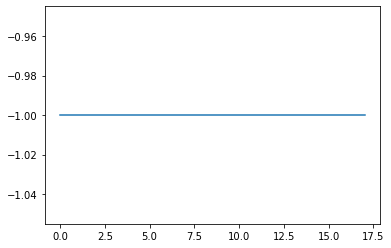

In [19]:
def findcenter(burst):
    burst = bursts.iloc[0]
    burstnum = burst[0][:2].strip('0') if burst[0][:2][0] == '0' else burst[0][:2]

    folder = 'data'
    filename = burst.filename
    edge = burst.edge

    junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    Q, U, V = None, None, None
    n = len(junk)
    print("Data loaded")

    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    tmin = 500 
    tmax = 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=False):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :

            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)


        for j in range(tmax+1,binmax+1) :

            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - (a+b)/2

    burstwindow = intensity[:,edge:edge+frequencymax]
    plt.imshow(burstwindow, interpolation='bicubic', origin='lower', cmap='gray')
    plt.title('Burst #{}'.format(burstnum))
    freqspectrum = pd.DataFrame(burstwindow[:,:].sum(axis=1)[:, None])
    data = freqspectrum[50:463][0]
    x = data.keys()
    xo = sum(x*data)/sum(data)
    return -1 # return the central frequency 

bursts['center'] = bursts.apply(findcenter, axis=1)
bursts['center'].plot()
